# Description of the final project

## Introduction

This project is devoted to the question-answering task. You are going to work with the **BoolQ** dataset from SuperGLUE .

BoolQ is a question answering dataset for yes/no. 

Each example is a triplet of (question, passage, answer), with the title of the page as optional additional context. The dataset release consists of three `.jsonl` files (`train, val, test`), where each line is a JSON dictionary with the following format:

    Example:
    
    {
      "question": "is france the same timezone as the uk",
      "passage": "At the Liberation of France in the summer of 1944, Metropolitan France kept GMT+2 as it was the time then used by the Allies (British Double Summer Time). In the winter of 1944--1945, Metropolitan France switched to GMT+1, same as in the United Kingdom, and switched again to GMT+2 in April 1945 like its British ally. In September 1945, Metropolitan France returned to GMT+1 (pre-war summer time), which the British had already done in July 1945. Metropolitan France was officially scheduled to return to GMT+0 on November 18, 1945 (the British returned to GMT+0 in on October 7, 1945), but the French government canceled the decision on November 5, 1945, and GMT+1 has since then remained the official time of Metropolitan France."
      "answer": false,
      "title": "Time in France",
    }

For this project you will need only `train` and `val` parts.

Dataset is available here: https://dl.fbaipublicfiles.com/glue/superglue/data/v2/BoolQ.zip

Detailed task description is available here: https://arxiv.org/abs/1905.10044

## Bonus for those, who want to work with Russian

For those who want to work with Russian data there is an option to use **DaNetQA** dataset (instead of BoolQ) from Russsian SuperGLUE. The dataset is organised similarly to BoolQ.

You may download data from here: https://russiansuperglue.com/tasks/download/DaNetQA

Detailed task description is available here: https://arxiv.org/abs/2010.02605


**Note:** note that you should take only one dataset (either BoolQ or DanetQA). There are no bonus points for solving both tasks.



# 1. Data analysis

### Download DB to Google Disk Storage

In [ ]:
from google.colab import drive


drive.mount('/content/drive')

In [ ]:
!wget -P drive/MyDrive/nlp/DaNetQA https://russiansuperglue.com/tasks/download/DaNetQA
!unzip drive/MyDrive/nlp/DaNetQA/DaNetQA -d drive/MyDrive/nlp/DaNetQA/

In [4]:
# Read DaNetQA to Dataframes (train && validation)

import pandas as pd


f_dir = 'drive/MyDrive/nlp/DaNetQA'

f_train_path = f'{f_dir}/train.jsonl'
f_val_path = f'{f_dir}/val.jsonl'

train_df = pd.read_json(f_train_path, lines=True)
train_df.set_index('idx',inplace=True)

val_df = pd.read_json(f_val_path, lines=True)
val_df.set_index('idx',inplace=True)

train_df.head(3)

,question,passage,label
idx,,,
0,Вднх - это выставочный центр?,«Вы́ставочный центр» — станция Московского мон...,True
1,Вднх - это выставочный центр?,"Вы́ставка достиже́ний наро́дного хозя́йства ,...",True
2,Был ли джиган в black star?,Вместе с этим треком они выступили на церемони...,True


## Calculate basic statistics

In [5]:
# Example

sample = train_df.sample(n=1)

id = sample.index.item()
question = sample['question'].item()
passage = sample['passage'].item()
label = sample['label'].item()

print('Example:\n')
print(f'id:\t\t{id}\nquestion:\t{question}\npassage:\t{passage}\nlabel:\t\t{label}')

Example:

id:		253
question:	Передается ли еврейство по отцу?
passage:	Негалахические евреи — граждане Израиля еврейского происхождения, не признаваемые государством как евреи на основе религиозного закона Галаха. В Израиле, в соответствии с Галахой, принадлежность к еврейству определяется по матери. Начиная с 2010 года, любой, кто иммигрировал в Израиль после 1990 года и желает вступить в брак или развестись по еврейской традиции, должен пройти «тест на еврейство» в еврейском религиозном суде. Во многих других государствах молодые люди, имеющие родителей разных национальностей, имеют возможность выбрать национальность любого из родителей исходя из личных предпочтений. Вследствие этого множество граждан других государств, считающих себя или числящихся по личным документам евреями в странах исхода, в Израиле таковыми не считаются.
label:		False


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


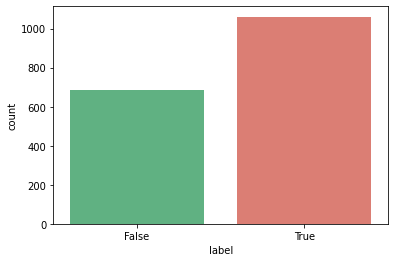

In [6]:
# Look for target class (answer) distribution with a bar plot

import seaborn as sns


red = '#EC7063'
green = '#52BE80'
blue = '#5DADE2'

sns.countplot(train_df['label'], palette=[green, red])

In [ ]:
# Prepare for tokenize text in the dataframe records

import string
import nltk

from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize


nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')


def tokenize(text):
    tokens = word_tokenize(text)
    tokens = [i for i in tokens if (i not in string.punctuation)]
    
    # deleting stop_words
    stop_words = stopwords.words('russian')
    stop_words.extend(['что', 'это', 'так', 'вот', 'быть', 'как', 'в', '—', '–', 'к', 'на', '...'])
    tokens = [i for i in tokens if (i not in stop_words)]
    
    # cleaning words
    tokens = [i.replace('«', '').replace('»', '') for i in tokens]
    tokens = [i.lower() for i in tokens if i != '']
    
    return tokens


def tokenize_sent(text):
    sentences = [tokenize(sent) for sent in sent_tokenize(text, 'russian')]
    return sentences


In [8]:
# Do tokenize

train_df['tokenized_question'] = train_df['question'].apply(tokenize_sent)
train_df['tokenized_passage'] = train_df['passage'].apply(tokenize_sent)

val_df['tokenized_question'] = val_df['question'].apply(tokenize_sent)
val_df['tokenized_passage'] = val_df['passage'].apply(tokenize_sent)

train_df['question_cnt_sent'] = train_df['tokenized_question'].apply(lambda x: len(x))
train_df['question_cnt_tokens'] = train_df['tokenized_question'].apply(lambda x: sum([len(i) for i in x]))

train_df['passage_cnt_sent'] = train_df['tokenized_passage'].apply(lambda x: len(x))
train_df['passage_cnt_tokens'] = train_df['tokenized_passage'].apply(lambda x: sum([len(i) for i in x]))

train_df.head(2)

,question,passage,label,tokenized_question,tokenized_passage,question_cnt_sent,question_cnt_tokens,passage_cnt_sent,passage_cnt_tokens
idx,,,,,,,,,
0,Вднх - это выставочный центр?,«Вы́ставочный центр» — станция Московского мон...,True,"[[вднх, выставочный, центр]]","[[вы́ставочный, центр, станция, московского, м...",1,3,5,50
1,Вднх - это выставочный центр?,"Вы́ставка достиже́ний наро́дного хозя́йства ,...",True,"[[вднх, выставочный, центр]]","[[вы́ставка, достиже́ний, наро́дного, хозя́йст...",1,3,6,100


In [9]:
# Statistics of tokens and sentences in question && passge records
# like in the paper (https://arxiv.org/pdf/2010.02605.pdf) page 4

q_data = train_df['question_cnt_tokens']
p_data = train_df['passage_cnt_tokens']

stat_df = pd.DataFrame(
    {'Count': [q_data.sum(), p_data.sum()], 
     'Mean': [round(q_data.mean(), 2), round(p_data.mean(), 2)],
     'Min': [q_data.min(), p_data.min()], 
     '25%': [q_data.quantile(q=0.25), p_data.quantile(q=0.25)],
     '50%': [q_data.quantile(q=0.5), p_data.quantile(q=0.5)],
     '75%': [q_data.quantile(q=0.75), p_data.quantile(q=0.75)],
     '95%': [q_data.quantile(q=0.95), p_data.quantile(q=0.95)],
     'Max': [q_data.max(), p_data.max()]},
     index=['Questions', 'Paragraphs']
)

print('Descriptive statistics of collected question/paragraph pairs (in tokens)')
stat_df

Descriptive statistics of collected question/paragraph pairs (in tokens)


,Count,Mean,Min,25%,50%,75%,95%,Max
Questions,7874,4.50,2,3.0,4.0,5.0,9.0,21
Paragraphs,131102,74.96,35,56.0,68.0,84.0,130.0,346


In [10]:
# Statistics of records in Train && validation Sets
# like in the paper (https://arxiv.org/pdf/2010.02605.pdf) page 4

stat_df = pd.DataFrame(
    {'Size': [len(train_df), len(val_df)], 
     '#Yes': [
              len(train_df[train_df['label'] == True]),
              len(val_df[val_df['label'] == True])
      ],
      'Yes%': [
               round(len(train_df[train_df['label'] == True]) /
                     len(train_df), 2),
               round(len(val_df[val_df['label'] == True]) /
                     len(val_df), 2)
      ],
     '#No': [
             len(train_df[train_df['label'] == False]),
             len(val_df[val_df['label'] == False])
      ],
      'No%': [
               round(len(train_df[train_df['label'] == False]) /
                     len(train_df), 2),
               round(len(val_df[val_df['label'] == False]) /
                     len(val_df), 2)
      ]},
     index=['Train set', 'Val set']
)

print('The number of yes/no questions in Test and Val sets. Symbol # stands for the total number of yes (or no) questions and % stands for the ratio of yes (or no) questions in the dataset.')
stat_df

The number of yes/no questions in Test and Val sets. Symbol # stands for the total number of yes (or no) questions and % stands for the ratio of yes (or no) questions in the dataset.


,Size,#Yes,Yes%,#No,No%
Train set,1749,1061,0.61,688,0.39
Val set,821,412,0.50,409,0.50


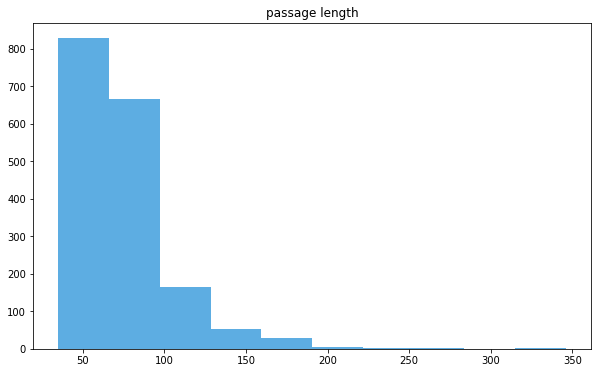

In [11]:
# Histogram of passgae sentences lengths

import matplotlib.pyplot as plt


def get_sentences_len_histogram(fig_size = (10,6), _class=None, color=blue):
    f, ax = plt.subplots(figsize=fig_size)

    if str(_class) == 'None':
        text_len = train_df['passage_cnt_tokens']
        ax.set_title('passage length')
        ax.hist(text_len, color=color)
    else:
        text_len = train_df[train_df['label'] == _class]['passage_cnt_tokens']
        ax.set_title(f'{_class} passage length ')
        ax.hist(text_len, color=color)

    return ax


get_sentences_len_histogram()

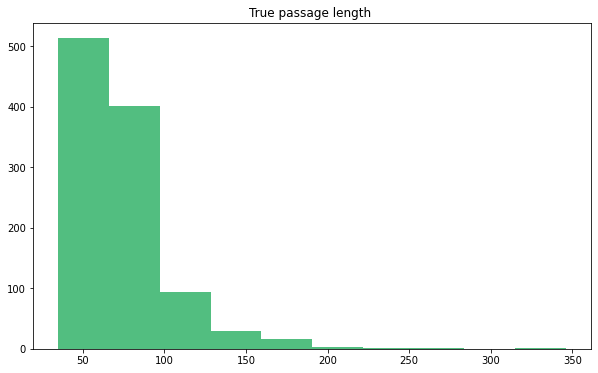

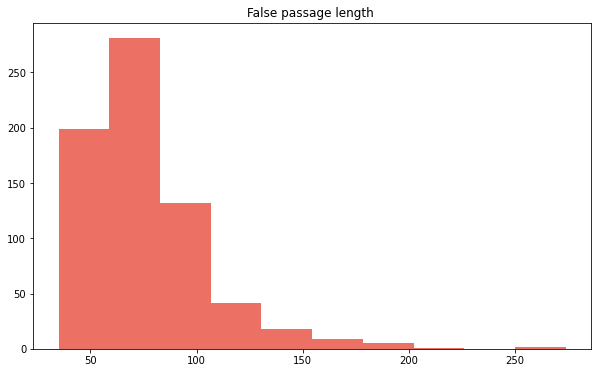

In [12]:
# Histogram of passgae sentences lengths by target value (answer)

ax1 = get_sentences_len_histogram(_class=True, color=green)
ax1 = get_sentences_len_histogram(_class=False, color=red)

In [13]:
# Statistics of tokens frequencies

from collections import OrderedDict
from operator import itemgetter


dictionary = {}

for _, sents in train_df['tokenized_question'].iteritems():
    for sent in sents:
        for token in sent:
            cnt = dictionary.setdefault(token, 1) + 1
            dictionary[token] = cnt

sorted_dictionary = OrderedDict(sorted(dictionary.items(), key = itemgetter(1), reverse=True))

In [14]:
DICT_SIZE = 15
VECTOR_SIZE = 300

stat_df = pd.DataFrame(
    {'Tokens': list(sorted_dictionary)[:DICT_SIZE], 
     'Frequency': list(sorted_dictionary.values())[:DICT_SIZE]}
)

print(f'Length of dictionary: {len(dictionary)}')
print(f'TOP-{DICT_SIZE} tokens for Train set in questions && passage')
stat_df

Length of dictionary: 4175
TOP-15 tokens for Train set in questions && passage


,Tokens,Frequency
0,был,311
1,есть,188
2,была,149
3,были,105
4,входит,90
5,едят,49
6,правда,38
7,россии,38
8,ссср,35
9,является,33


# 2. Pretrained embeddings as features for classifier

2.1 (5%) Take pre-trained word2vec or fastText embeddings and vectorize your data using them.
Note: you may use any pre-trained embeddings available on the Internet. For example, for English you may take GoogleNews vectors, which are available here: https://www.kaggle.com/leadbest/googlenewsvectorsnegative300 . For the Russian language you may choose one of the models from RusVectores (https://rusvectores.org/ru/models/).

In [ ]:
# Downloading pretraining model from https://rusvectores.org/ru/models/

!wget -P drive/MyDrive/nlp/model http://vectors.nlpl.eu/repository/20/180.zip
!unzip drive/MyDrive/nlp/model/180.zip -d drive/MyDrive/nlp/model

In [ ]:
!pip install --upgrade gensim --user
!pip install fasttext

In [16]:
import numpy as np
from gensim import models


model_path = '/content/drive/MyDrive/nlp/model/model.bin'
wv_model = models.KeyedVectors.load_word2vec_format(model_path, binary=True)

In [17]:
# Function for victorize text (list of tokens)

def flatten_doc(doc):
    flatten = [x for b in doc for x in b]
    return flatten


def document_vector(model, doc):
    doc = flatten_doc(doc)

    # Because word2vec model has words with postfix as part of speach,
    # for example: 'слово_NOUN'
    docs = [word + '_NOUN' for word in doc if word + '_NOUN' in model]

    if len(docs) > 0:
        vector = np.mean(model[docs], axis=0)
    else:
        vector = np.zeros(VECTOR_SIZE)

    return vector

In [18]:
# Convert values in label (bool-answers) from bool -> int

train_df['target'] = train_df['label'].astype(int)
val_df['target'] = val_df['label'].astype(int)

In [19]:
# Vectorize question and passage texts

train_df['question_vector'] = train_df['tokenized_question'].apply(lambda x: document_vector(wv_model, x))
train_df['passage_vector'] = train_df['tokenized_passage'].apply(lambda x: document_vector(wv_model, x))

val_df['question_vector'] = val_df['tokenized_question'].apply(lambda x: document_vector(wv_model, x))
val_df['passage_vector'] = val_df['tokenized_passage'].apply(lambda x: document_vector(wv_model, x))


train_df.head(3)

,question,passage,label,tokenized_question,tokenized_passage,question_cnt_sent,question_cnt_tokens,passage_cnt_sent,passage_cnt_tokens,target,question_vector,passage_vector
idx,,,,,,,,,,,,
0,Вднх - это выставочный центр?,«Вы́ставочный центр» — станция Московского мон...,True,"[[вднх, выставочный, центр]]","[[вы́ставочный, центр, станция, московского, м...",1,3,5,50,1,"[-2.5274274, 1.4573482, -1.0101535, -0.5003862...","[-0.38997227, -0.11845597, 0.14628886, 0.20173..."
1,Вднх - это выставочный центр?,"Вы́ставка достиже́ний наро́дного хозя́йства ,...",True,"[[вднх, выставочный, центр]]","[[вы́ставка, достиже́ний, наро́дного, хозя́йст...",1,3,6,100,1,"[-2.5274274, 1.4573482, -1.0101535, -0.5003862...","[-0.37122914, 0.0024830045, 0.4176636, 0.21560..."
2,Был ли джиган в black star?,Вместе с этим треком они выступили на церемони...,True,"[[был, джиган, black, star]]","[[вместе, этим, треком, выступили, церемонии, ...",1,4,5,65,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.606972, -0.0048395, 0.3137106, 0.02318198, ..."


2.2 (15%) Use pretrained embeddings as features to a classifier. Train SVM, Linear Regression or any other classification model. Describe and analyze your results (use accuracy metric and data from val.jsonl for evaluation of your results).

In [20]:
# Do train && test sets for LR classifier

X_train = list(train_df.apply(lambda x: list(x.question_vector) + list(x.passage_vector), axis=1))
y_train = list(train_df['target'])

X_test = list(val_df.apply(lambda x: np.array(list(x.question_vector) + list(x.passage_vector)), axis=1))
y_test = list(val_df['target'].values)

In [21]:
# Train SVM for classification

import sklearn.metrics as metrics
import matplotlib.pyplot as plt

from sklearn.svm import SVC


svc = SVC(C=1.0, random_state=1, kernel='linear')
svc.fit(X_train, y_train)

y_pred = svc.predict(X_test)

In [22]:
# Measure the performance

accuracy = metrics.accuracy_score(y_test, y_pred)
mse = metrics.mean_squared_error(y_test, y_pred)
average_precision = metrics.average_precision_score(y_test, y_pred)

print(f'Accuracy score {round(accuracy, 3)}')
print(f'Mean Squared Error {round(mse, 3)}')
print(f'Average precision-recall score: {round(average_precision, 3)}')

Accuracy score 0.592
Mean Squared Error 0.408
Average precision-recall score: 0.554


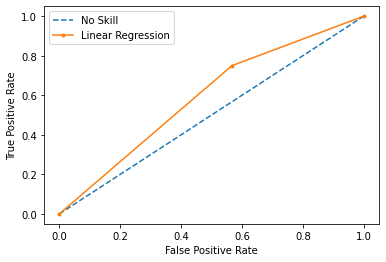

In [23]:
# Calculate roc curves

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)

# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Linear Regression')

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

2.3 (5%) Instead of word2vec or fastText embeddings get BERT embeddings from the train dataset and vectorize your data.
Note: you may use any of the BERT-like models from hugging face (https://huggingface.co/) library. For example, you may use bert-base-multilingual-cased (https://huggingface.co/bert-base-multilingual-cased).

In [ ]:
# Install Torch && Transformers libs

!pip install transformers
!pip install torch torchvision

In [ ]:
# Model loading
# I used this pretrained BERT-model https://huggingface.co/bert-base-multilingual-cased

import torch
import transformers
from transformers import BertTokenizer, BertModel, BertForQuestionAnswering


tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = BertModel.from_pretrained('bert-base-multilingual-cased')
model.to(device)

In [48]:
# Check BERT tokenizer in one simple example

text_exmpl = 'Пример текста для проверки токенизации.'

print('Original: ', text_exmpl)
print('Tokenized: ', tokenizer.tokenize(text_exmpl))
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(text_exmpl)))

Original:  Пример текста для проверки токенизации.
Tokenized:  ['пример', 'текста', 'для', 'про', '##вер', '##ки', 'ток', '##ени', '##зации', '.']
Token IDs:  [32725, 77572, 10520, 12709, 32418, 10648, 84964, 15065, 33917, 119]


In [40]:
from sklearn.base import TransformerMixin, BaseEstimator
from typing import Callable, List, Optional, Tuple


class BertTransformer(BaseEstimator, TransformerMixin):
    def __init__(
            self,
            bert_tokenizer,
            bert_model,
            max_length: int = 60,
            embedding_func: Optional[Callable[[torch.tensor], torch.tensor]] = None,
    ):
        self.tokenizer = bert_tokenizer
        self.model = bert_model
        self.model.eval()
        self.max_length = max_length
        self.embedding_func = embedding_func

        if self.embedding_func is None:
            self.embedding_func = lambda x: x[0][:, 0, :].squeeze()

    def _tokenize(self, question: str, passage: str) -> Tuple[torch.tensor, torch.tensor]:
        # Tokenize the text with the provided tokenizer
        encoded_data = self.tokenizer.encode_plus(question, 
                                                  passage,
                                                  add_special_tokens=True,
                                                  max_length=self.max_length,
                                                  padding='max_length',
                                                  truncation=True
                                                  )
        
        encoded_pair = encoded_data['input_ids']
        attention_mask = encoded_data['attention_mask']

        # bert takes in a batch so we need to unsqueeze the rows
        return (
            torch.tensor(encoded_pair).unsqueeze(0),
            torch.tensor(attention_mask).unsqueeze(0),
        )

    def _tokenize_and_predict(self, question: str, passage: str) -> torch.tensor:
        tokenized, attention_mask = self._tokenize(question, passage)
        embeddings = self.model(tokenized, attention_mask)
        
        return self.embedding_func(embeddings)

    def transform(self, data: tuple):
        with torch.no_grad():
            return torch.stack([self._tokenize_and_predict(question, passage) for question, passage in data])

    def fit(self, X, y=None):
        """No fitting necessary so we just return ourselves"""
        return self

In [41]:
# Do train && test sets for classifier

X_train = zip(list(train_df['question']), list(train_df['passage']))
y_train = list(train_df['target'])

X_test = zip(list(val_df['question']), list(val_df['passage']))
y_test = list(val_df['target'])

2.4 (15%) Similarly to 2.1, train SVM, Linear Regression or any other classification model using BERT embeddings as features for a classifier. Describe and analyze your results (use accuracy metric and data from val.jsonl for evaluation of your results).

In [42]:
# Fit the model && predict

from sklearn.pipeline import Pipeline
from sklearn import svm


bert_transformer = BertTransformer(tokenizer, model)

classifier = svm.LinearSVC(C=1.0, class_weight='balanced')

model = Pipeline(
    [
        ("vectorizer", bert_transformer),
        ("classifier", classifier),
    ]
)

In [ ]:
model.fit(X_train, y_train)

In [45]:
y_pred = model.predict(X_test)

In [46]:
# Measure the performance

accuracy = metrics.accuracy_score(y_test, y_pred)
mse = metrics.mean_squared_error(y_test, y_pred)
average_precision = metrics.average_precision_score(y_test, y_pred)

print(f'Accuracy score {round(accuracy, 3)}')
print(f'Mean Squared Error {round(mse, 3)}')
print(f'Average precision-recall score: {round(average_precision, 3)}')

Accuracy score 0.559
Mean Squared Error 0.441
Average precision-recall score: 0.534


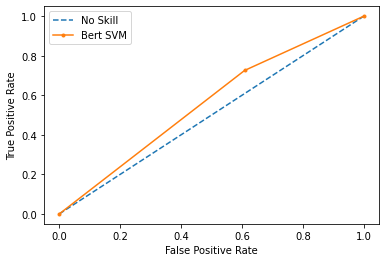

In [56]:
# Calculate roc curves

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)

# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Bert SVM')

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

# [40%] 3. Fine-tune BERT

3.1 (10%) Split the data from train.jsonl into train and dev (dev_size = 10%) . Tokenize and format the data (do not forget about the [SEP] token).

In [49]:
# Split the data from train.jsonl into train and dev (dev_size = 10%)

from sklearn.model_selection import train_test_split


train_data, dev_data = train_test_split(train_df, test_size=0.1)

passages_train = train_data['passage'].values
questions_train = train_data['question'].values
answers_train = train_data['label'].values.astype(int)

passages_dev = dev_data['passage'].values
questions_dev = dev_data['question'].values
answers_dev = dev_data['label'].values.astype(int)

print(f'Size of Train set: {len(train_data)}\nSize of Dev set: {len(dev_data)}')

Size of Train set: 1574
Size of Dev set: 175


In [50]:
from transformers import AutoTokenizer


tokenizer = AutoTokenizer.from_pretrained('bert-base-multilingual-cased')

In [51]:
# Encode the question/passage pairs into features than can be fed to the model

def encode_data(tokenizer, questions, passages, max_length):
    input_ids = []
    attention_masks = []

    for question, passage in zip(questions, passages):
        encoded_data = tokenizer.encode_plus(question, passage, max_length=max_length, padding='max_length', truncation=True)
        encoded_pair = encoded_data['input_ids']
        attention_mask = encoded_data['attention_mask']

        input_ids.append(encoded_pair)
        attention_masks.append(attention_mask)

    return np.array(input_ids), np.array(attention_masks)

In [52]:
# Vectorize data

max_seq_length = 128 #256

input_ids_train, attention_masks_train = encode_data(tokenizer, questions_train, passages_train, max_seq_length)
input_ids_dev, attention_masks_dev = encode_data(tokenizer, questions_dev, passages_dev, max_seq_length)

train_features = (input_ids_train, attention_masks_train, answers_train)
dev_features = (input_ids_dev, attention_masks_dev, answers_dev)

3.2 (10%) Initialize the model, optimizer and learning rate scheduler. Explain your choice of the parameters.

In [ ]:
from transformers import AutoModelForSequenceClassification, AdamW


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = AutoModelForSequenceClassification.from_pretrained('bert-base-multilingual-cased')
model.to(device)

epochs = 3
grad_acc_steps = 1
train_loss_values = []
dev_acc_values = []

learning_rate = 1e-5
optimizer = AdamW(model.parameters(), lr=learning_rate, eps=1e-8)

3.3 (10%) Write a training loop and fine-tune BERT. Do to forget about evaluation on dev set created in 3.1.
Note: you may use one of the tutorials for fine-tuning BERT, but you have to provide a link to it. For example, you may use this one: https://mccormickml.com/2019/07/22/BERT-fine-tuning/

In [54]:
# Building Dataloaders
# One more tutorial: https://medium.com/illuin/deep-learning-has-almost-all-the-answers-yes-no-question-answering-with-transformers-223bebb70189

from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler


batch_size = 32

train_features_tensors = [torch.tensor(feature, dtype=torch.long) for feature in train_features]
dev_features_tensors = [torch.tensor(feature, dtype=torch.long) for feature in dev_features]

train_dataset = TensorDataset(*train_features_tensors)
dev_dataset = TensorDataset(*dev_features_tensors)

train_sampler = RandomSampler(train_dataset)
dev_sampler = SequentialSampler(dev_dataset)

train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size)
dev_dataloader = DataLoader(dev_dataset, sampler=dev_sampler, batch_size=batch_size)

In [55]:
# Training the model

for _ in tqdm(range(epochs), desc='Epoch'):
    # Training
    epoch_train_loss = 0
    model.train()
    model.zero_grad()
    
    for step, batch in enumerate(train_dataloader):
      
        input_ids = batch[0].to(device)
        attention_masks = batch[1].to(device)
        labels = batch[2].to(device)
        
        outputs = model(input_ids, token_type_ids=None, attention_mask=attention_masks, labels=labels)
        
        loss = outputs[0]
        loss = loss / grad_acc_steps
        epoch_train_loss += loss.item()
        
        loss.backward()
        
        if (step+1) % grad_acc_steps == 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            model.zero_grad()
            
    epoch_train_loss = epoch_train_loss / len(train_dataloader)
    train_loss_values.append(epoch_train_loss)
    
    # Evaluation
    epoch_dev_accuracy = 0 # Cumulative accuracy
    model.eval()
    
    for batch in dev_dataloader:
      
        input_ids = batch[0].to(device)
        attention_masks = batch[1].to(device)
        labels = batch[2]

        with torch.no_grad():        
            outputs = model(input_ids, token_type_ids=None, attention_mask=attention_masks)
                        
        logits = outputs[0]
        logits = logits.detach().cpu().numpy()
        
        predictions = np.argmax(logits, axis=1).flatten()
        labels = labels.numpy().flatten()
    
        epoch_dev_accuracy += np.sum(predictions == labels) / len(labels)

    epoch_dev_accuracy = epoch_dev_accuracy / len(dev_dataloader)
    dev_acc_values.append(epoch_dev_accuracy)

Epoch: 100%|██████████| 3/3 [1:39:59<00:00, 1999.98s/it]


In [57]:
# Save the model

torch.save(model, f'{f_dir}/model')

In [ ]:
# Load the model

model = torch.load(f'{f_dir}/model')

In [58]:
# Report the final accuracy for this validation run

print(f'Accuracy: {round(epoch_dev_accuracy, 2)}')

Accuracy: 0.76


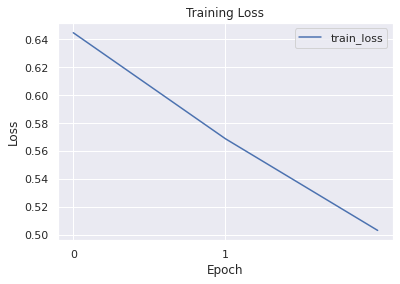

In [60]:
sns.set()

plt.plot(train_loss_values, label="train_loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()
plt.xticks(np.arange(0, 2))
plt.show()

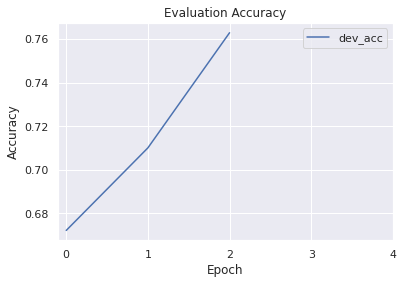

In [61]:
plt.plot(dev_acc_values, label="dev_acc")

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Evaluation Accuracy")
plt.legend()
plt.xticks(np.arange(0, 2))
plt.show()

3.4 (10%) Make predictions for the test data (from val.jsonl), and analyze the results (use accuracy metric for scoring).

In [62]:
# Vectorize val data

passages_val = val_df['passage'].values
questions_val = val_df['question'].values
answers_val = val_df['target'].values.astype(int)

input_ids_val, attention_masks_val = encode_data(tokenizer, questions_val, passages_val, max_seq_length)
val_features = (input_ids_val, attention_masks_val, answers_val)

val_features_tensors = [torch.tensor(feature, dtype=torch.long) for feature in val_features]
val_dataset = TensorDataset(*val_features_tensors)
val_sampler = RandomSampler(val_dataset)

val_dataloader = DataLoader(val_dataset, sampler=val_sampler, batch_size=batch_size)

In [63]:
# Prediction on val set
# I used this article https://mccormickml.com/2019/07/22/BERT-fine-tuning/ for prediction logics

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in val_dataloader:
    batch = tuple(t.to(device) for t in batch)
    
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    
    # Telling the model not to compute or store gradients, saving memory and 
    # speeding up prediction
    with torch.no_grad():
        # Forward pass, calculate logit predictions
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    logits = outputs[0]

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)

In [64]:
# We use MCC here because the classes are imbalanced:

print('Positive samples: %d of %d (%.2f%%)' % (val_df['target'].sum(), len(val_df['target']), (val_df['target'].sum() / len(val_df['target']) * 100.0)))

Positive samples: 412 of 821 (50.18%)


In [ ]:
from sklearn.metrics import matthews_corrcoef


matthews_set = []

# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating Matthews Corr. Coef. for each batch...')

# For each input batch...
for i in range(len(true_labels)):
  
  # The predictions for this batch are a 2-column ndarray (one column for "0" 
  # and one column for "1"). Pick the label with the highest value and turn this
  # in to a list of 0s and 1s.
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
  
  # Calculate and store the coef for this batch.  
  matthews = matthews_corrcoef(true_labels[i], pred_labels_i)                
  matthews_set.append(matthews)

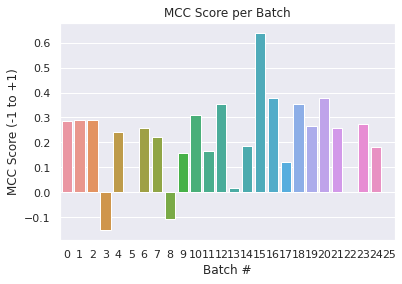

In [66]:
# Create a barplot showing the MCC score for each batch of test samples.
ax = sns.barplot(x=list(range(len(matthews_set))), y=matthews_set, ci=None)

plt.title('MCC Score per Batch')
plt.ylabel('MCC Score (-1 to +1)')
plt.xlabel('Batch #')

plt.show()

In [67]:
# Combine the results across all batches. 
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

# Calculate the MCC
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print(f'Total MCC: {round(mcc, 2)}')

Total MCC: 0.21


# [10%] 4. Summary & results analysis

I was surprised that BERT-embedded classifier showed result with low accuracy: less then simple linear regression classifier. Maybe I should have used another method for form vector for bert-model.

It is so logical that the fine-tuned bert-model should return the best result among all used models, but I can't get it. But some optimization for model parameters (like Batch Size [16, 32], Epochs [2, 3, 4], Learning rate [5e-5, 3e-5, 2e-5]) can by optimized for even better results.